# Produce measures as Rt for other countries 
Source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv

In [34]:
from math import exp

import epyestim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from epyestim import covid19
from scipy.stats import gamma, lognorm

## Loading data

In [35]:
df_ts_other_countries = pd.read_csv('data/input/OurWorldData/owid-covid-data.csv')
df_ts_other_countries.date = pd.to_datetime(df_ts_other_countries.date)

## Filtering data

In [36]:
df_ts_other_countries = df_ts_other_countries[df_ts_other_countries.location.isin(['United States', 'Belgium', 'Denmark', 'Hungary', 'Luxembourg', 'Norway', 'Portugal', 'Spain', 'United Kingdom'])]
date_limit_comprise_2022 = pd.to_datetime('2021-01-18')
df_ts_other_countries = df_ts_other_countries[df_ts_other_countries.date <= pd.to_datetime('2022-12-31')]
df_ts_other_countries

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
29407,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923.0,NaN,NaN,NaN,NaN
29408,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923.0,NaN,NaN,NaN,NaN
29409,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923.0,-151.3,-6.34,-6.34,-13.086293
29410,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923.0,NaN,NaN,NaN,NaN
29411,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334028,USA,North America,United States,2022-12-27,99019493.0,0.0,72572.714,1079976.0,0.0,433.286,...,24.6,NaN,2.77,78.86,0.926,338289856.0,NaN,NaN,NaN,NaN
334029,USA,North America,United States,2022-12-28,99019493.0,0.0,72572.714,1079976.0,0.0,433.286,...,24.6,NaN,2.77,78.86,0.926,338289856.0,NaN,NaN,NaN,NaN
334030,USA,North America,United States,2022-12-29,99019493.0,0.0,72572.714,1079976.0,0.0,433.286,...,24.6,NaN,2.77,78.86,0.926,338289856.0,NaN,NaN,NaN,NaN
334031,USA,North America,United States,2022-12-30,99411696.0,392203.0,56029.000,1082456.0,2480.0,354.286,...,24.6,NaN,2.77,78.86,0.926,338289856.0,NaN,NaN,NaN,NaN


## Adjusting missing data

In [37]:
df_ts_other_countries.new_deaths = df_ts_other_countries.new_deaths.fillna(0)

## Calculating measures

In [38]:
df_ts_other_countries = df_ts_other_countries.sort_values(['location','date'])
df_ts_other_countries['rate_new_deaths'] = df_ts_other_countries.new_deaths / df_ts_other_countries.population * 100000
df_ts_other_countries['rate_new_deaths_moving_average'] = df_ts_other_countries.groupby('location')['rate_new_deaths'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_ts_other_countries['new_deaths_moving_average'] = df_ts_other_countries.groupby('location')['new_deaths'].transform(lambda x: x.rolling(7, min_periods=1).mean())

In [39]:
df_ts_other_countries['rate_new_cases'] = df_ts_other_countries.new_cases / df_ts_other_countries.population * 100000
df_ts_other_countries['rate_new_cases_moving_average'] = df_ts_other_countries.groupby('location')['rate_new_cases'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_ts_other_countries['new_cases_moving_average'] = df_ts_other_countries.groupby('location')['new_cases'].transform(lambda x: x.rolling(7, min_periods=1).mean())

## Estimating effective reproduction number based in death time series


In [40]:
#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Gamma distribution with serial interval mean equal to 6.36 days, gamma(a=2.29, b=0.36)
standard_serial_inteval_distribution = epyestim.discrete_distrb(gamma(a=2.29, scale=1/0.36))

#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Lognormal distribution with incabation mean equal to 5.93 days, Lognormal(mu=1.57, sigma²=0.42)
incubation_time_distribution = epyestim.discrete_distrb(lognorm(scale=exp(1.57), s=0.65))

# Verity, Robert, et al. "Estimates of the severity of coronavirus disease 2019: a model-based analysis." The Lancet infectious diseases 20.6 (2020): 669-677.
# Gamma distribution with delay mean equal to 18.8 days
mean_days_delay_onset_to_death = 18.8  # mean days onset to death.
s_death = 0.45
shape_death = 1/(s_death**2)
scale_death= mean_days_delay_onset_to_death * s_death ** 2
delay_onset_to_death_distribution = epyestim.discrete_distrb(gamma(a=shape_death, scale=scale_death))

# Distribution resultant of convolution incubation_time_distribution and delay_onset_to_notification_distribution.
# Represent delay of infection to notification with delay mean equal to 24.02 days.
delay_infecton_to_death_distribution = np.convolve(incubation_time_distribution, delay_onset_to_death_distribution)

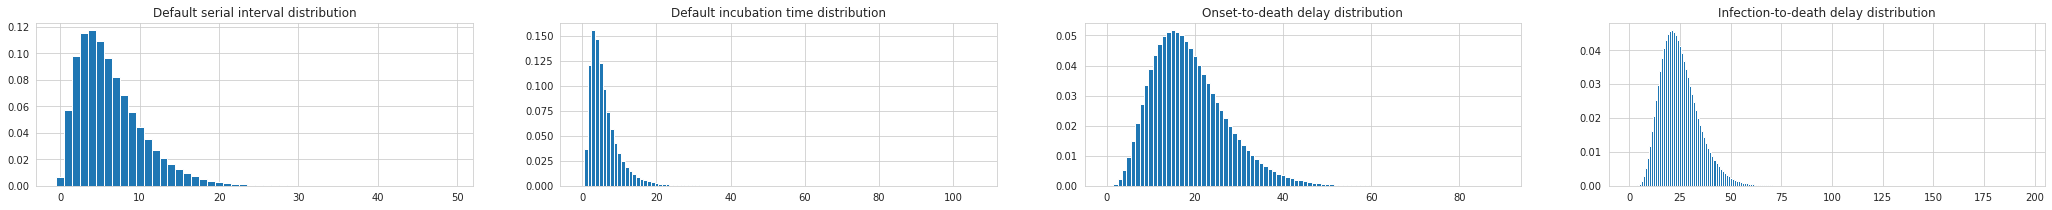

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(36,3))

axs[0].bar(range(len(standard_serial_inteval_distribution)), standard_serial_inteval_distribution, width=1)
axs[1].bar(range(len(incubation_time_distribution)), incubation_time_distribution, width=1)
axs[2].bar(range(len(delay_onset_to_death_distribution)), delay_onset_to_death_distribution, width=1)
axs[3].bar(range(len(delay_infecton_to_death_distribution)), delay_infecton_to_death_distribution, width=1)

axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default incubation time distribution')
axs[2].set_title('Onset-to-death delay distribution')
axs[3].set_title('Infection-to-death delay distribution')
plt.show()

In [42]:
window_days_onset_to_death = round(mean_days_delay_onset_to_death)
window_days_onset_to_death

19

In [43]:
df_ts_other_countries.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [44]:
window_days_onset_to_death = round(mean_days_delay_onset_to_death)
window_days_onset_to_death

19

In [45]:
df_with_rt = pd.DataFrame()

for country in df_ts_other_countries.location.unique():
    print(country)
    df_country = df_ts_other_countries[df_ts_other_countries.location == country].copy()
    survival_rate = (df_country.new_cases.sum() / df_country.new_deaths.sum())
    df_country['estimated_cases_by_deaths'] = df_country['new_deaths_moving_average'] * survival_rate
    df_country['estimated_onset_by_deaths'] = df_country['estimated_cases_by_deaths'].rolling(window=window_days_onset_to_death, min_periods=1).mean().shift(-(window_days_onset_to_death - 1))
    df_estimated_cases = df_country.set_index('date')['estimated_onset_by_deaths'].dropna()
    
    df_effective_reproduction_number_estimated_cases = covid19.r_covid(df_estimated_cases, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=delay_infecton_to_death_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)
    
    df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.reset_index()
    df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.rename(columns={'index': 'date', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975' })
    df_effective_reproduction_number_estimated_cases['location'] = country
    df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.drop(columns=['cases'])
    df_country = df_country.merge(df_effective_reproduction_number_estimated_cases, how='left', on=['location', 'date'])

    df_with_rt = pd.concat([df_with_rt, df_country])

Belgium
Denmark
Hungary
Luxembourg
Norway
Portugal
Spain
United Kingdom
United States


## Case fatality rate

In [46]:
df_with_cfr = pd.DataFrame()

for country in df_with_rt.location.unique():
    print(country)
    df_country = df_with_rt[df_with_rt.location == country].copy()
    df_country['TAXA_FATALIDADE'] = df_country.rate_new_deaths_moving_average / df_country.rate_new_cases_moving_average.shift(19) * 100
    
    df_with_cfr = pd.concat([df_with_cfr, df_country])

Belgium
Denmark
Hungary
Luxembourg
Norway
Portugal
Spain
United Kingdom
United States


## Saving data


In [47]:
df_with_cfr.to_csv('data/output/df_ts_other_countries_epidemic_parameters.csv')

In [48]:
df_with_cfr.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,rate_new_cases_moving_average,new_cases_moving_average,estimated_cases_by_deaths,estimated_onset_by_deaths,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975,TAXA_FATALIDADE
0,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_with_cfr.shape

(9846, 81)